# Toy Experiment Visual Dashboard

이 노트북은 `runs/toy` 결과를 모델별로 한눈에 비교하기 위한 시각화 대시보드입니다.
- 지원 모델 라벨: `M0~M4`
- 레거시 경로(`baseline/reg/struct`)도 자동 인식
- 학습 곡선, FID vs NFE, integrability sigma 곡선, 벡터장/컬(curl), 샘플 궤적 비교


In [1]:
from __future__ import annotations

import math
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml


def resolve_repo_root(start: Path) -> Path:
    """Resolve repository root by searching parent directories.

    Args:
        start: Starting path (usually notebook working directory).

    Returns:
        Repository root path containing `src/` and `configs/`.

    How it works:
        Iterates from `start` up to filesystem root and returns the first
        directory that looks like this project root.
    """
    for candidate in [start, *start.parents]:
        if (candidate / 'src').is_dir() and (candidate / 'configs').is_dir():
            return candidate
    raise RuntimeError(
        f'Could not locate repo root from {start}. '
        'Run the notebook from inside the Advance_score repository.'
    )


ROOT = resolve_repo_root(Path.cwd().resolve())
if str(ROOT) not in sys.path:
    # 로컬 src 모듈 임포트를 위해 repo 루트를 경로에 추가한다.
    sys.path.insert(0, str(ROOT))

from src.models import build_model, score_fn_from_model
from src.sampling import sample_heun
from src.utils.checkpoint import latest_checkpoint, load_checkpoint
from src.utils.config import ensure_experiment_defaults, resolve_model_id

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 200)

RUN_ROOT = ROOT / 'runs' / 'toy'
MODEL_ORDER = ['M0', 'M1', 'M2', 'M3', 'M4']
LEGACY_ALIAS = {
    'M0': ['M0', 'baseline'],
    'M1': ['M1', 'reg'],
    'M2': ['M2', 'struct'],
    'M3': ['M3'],
    'M4': ['M4'],
}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'ROOT={ROOT}')
print(f'RUN_ROOT={RUN_ROOT}')
print(f'DEVICE={DEVICE}')


ROOT=/home/junyeobe/projects/Advance_score
RUN_ROOT=/home/junyeobe/projects/Advance_score/runs/toy
DEVICE=cuda


In [2]:
def find_toy_run_dirs(run_root: Path, seed_name: str = 'seed0') -> dict[str, Path]:
    """Resolve model-id to run directory mapping under runs/toy.

    Args:
        run_root: Root path like `runs/toy`.
        seed_name: Seed directory name.

    Returns:
        Mapping `{model_id: run_dir}` for detected runs.

    How it works:
        For each model id in M0~M4, tries canonical folder first and
        then legacy aliases (baseline/reg/struct).
    """
    out: dict[str, Path] = {}
    for model_id in MODEL_ORDER:
        for folder in LEGACY_ALIAS.get(model_id, [model_id]):
            candidate = run_root / folder / seed_name
            if candidate.exists():
                out[model_id] = candidate
                break
    return out


def read_csv_if_exists(path: Path) -> pd.DataFrame:
    """Read CSV file if present, otherwise return empty DataFrame.

    Args:
        path: CSV path.

    Returns:
        Loaded DataFrame or empty DataFrame when file is missing.
    """
    if not path.exists():
        return pd.DataFrame()
    return pd.read_csv(path)


def maybe_run_eval(run_dir: Path, nfe_list: str = '10,20,50,100,200') -> None:
    """Run `src.main_eval` for a run when eval artifacts are missing.

    Args:
        run_dir: Run directory path.
        nfe_list: Comma-separated NFE list string.

    Returns:
        None. Subprocess call writes eval files in-place.
    """
    fid_path = run_dir / 'eval' / 'fid_vs_nfe.csv'
    integ_path = run_dir / 'eval' / 'integrability_vs_sigma.csv'
    if fid_path.exists() and integ_path.exists():
        return

    cmd = [
        sys.executable, '-m', 'src.main_eval',
        '--run_dir', str(run_dir),
        '--nfe_list', nfe_list,
    ]
    print('Running:', ' '.join(cmd))
    subprocess.run(cmd, check=True, cwd=str(ROOT))


def load_run_cfg(run_dir: Path) -> dict:
    """Load resolved run config YAML and normalize experiment defaults.

    Args:
        run_dir: Run directory containing `config_resolved.yaml`.

    Returns:
        Resolved config dictionary.
    """
    cfg_path = run_dir / 'config_resolved.yaml'
    with cfg_path.open('r', encoding='utf-8') as f:
        cfg = yaml.safe_load(f)
    return ensure_experiment_defaults(cfg)


def load_model_score_fn(run_dir: Path, device: torch.device):
    """Build model and score function from latest checkpoint.

    Args:
        run_dir: Run directory.
        device: Torch device used for model evaluation.

    Returns:
        Tuple `(cfg, model, score_fn)` where score_fn is graph-free.

    How it works:
        Uses `config_resolved.yaml` + latest checkpoint, applies EMA
        shadow weights when available, and returns unified score wrapper.
    """
    cfg = load_run_cfg(run_dir)
    model_id = resolve_model_id(cfg)

    model = build_model(cfg).to(device)
    ckpt_path = latest_checkpoint(run_dir)
    if ckpt_path is None:
        raise FileNotFoundError(f'No checkpoint found in {run_dir}')

    ckpt = load_checkpoint(ckpt_path, map_location=str(device))
    model.load_state_dict(ckpt['model'], strict=True)

    # EMA shadow가 있으면 평가에는 EMA를 우선 사용한다.
    ema = ckpt.get('ema')
    if isinstance(ema, dict) and 'shadow' in ema:
        model.load_state_dict(ema['shadow'], strict=False)

    model.eval()
    score_fn = score_fn_from_model(model, model_id, create_graph=False)
    return cfg, model, score_fn


def evaluate_score_grid(
    score_fn,
    sigma_value: float,
    xlim: tuple[float, float] = (-6.0, 6.0),
    ylim: tuple[float, float] = (-6.0, 6.0),
    points: int = 35,
    device: torch.device = torch.device('cpu'),
):
    """Evaluate 2D score field on a dense grid.

    Args:
        score_fn: Callable `score_fn(x, sigma)`.
        sigma_value: Scalar sigma used for entire grid.
        xlim: X-axis range.
        ylim: Y-axis range.
        points: Number of grid points per axis.
        device: Execution device.

    Returns:
        Tuple `(X, Y, U, V)` for quiver plotting.
    """
    xs = np.linspace(xlim[0], xlim[1], points)
    ys = np.linspace(ylim[0], ylim[1], points)
    X, Y = np.meshgrid(xs, ys)

    grid = np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
    x_tensor = torch.tensor(grid, dtype=torch.float32, device=device)
    sigma = torch.full((x_tensor.shape[0],), float(sigma_value), dtype=torch.float32, device=device)

    with torch.no_grad():
        score = score_fn(x_tensor, sigma).detach().cpu().numpy()

    U = score[:, 0].reshape(points, points)
    V = score[:, 1].reshape(points, points)
    return X, Y, U, V


def finite_diff_curl(U: np.ndarray, V: np.ndarray, xs: np.ndarray, ys: np.ndarray) -> np.ndarray:
    """Compute 2D curl proxy `dV/dx - dU/dy` via finite differences.

    Args:
        U: X-component field array.
        V: Y-component field array.
        xs: X-axis coordinates.
        ys: Y-axis coordinates.

    Returns:
        Curl array with same shape as `U`/`V`.
    """
    dV_dy, dV_dx = np.gradient(V, ys, xs, edge_order=2)
    dU_dy, dU_dx = np.gradient(U, ys, xs, edge_order=2)
    return dV_dx - dU_dy


In [3]:
toy_runs = find_toy_run_dirs(RUN_ROOT, seed_name='seed0')
print('Detected toy runs:')
for model_id in MODEL_ORDER:
    print(f'  {model_id}: {toy_runs.get(model_id)}')

# 필요 시 True로 바꿔 eval csv를 자동 생성한다.
RUN_EVAL_IF_MISSING = False
if RUN_EVAL_IF_MISSING:
    for run_dir in toy_runs.values():
        maybe_run_eval(run_dir, nfe_list='10,20,50,100,200')


Detected toy runs:
  M0: /home/junyeobe/projects/Advance_score/runs/toy/M0/seed0
  M1: /home/junyeobe/projects/Advance_score/runs/toy/reg/seed0
  M2: /home/junyeobe/projects/Advance_score/runs/toy/struct/seed0
  M3: None
  M4: None


,step,loss_total,loss_dsm,loss_sym,loss_loop,loss_loop_multi,loss_cycle,loss_match,grad_norm_mean,grad_norm_max,nan_count,step_time_ms,imgs_per_sec,vram_peak_mb,model_id
0,1,1.022452,1.022452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,462.813212,2212.555678,30.656250,M0
1,50,0.980221,0.980221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12.735570,80404.724722,32.799805,M0
2,100,0.942591,0.942591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,13.779701,74312.207499,32.799805,M0
3,150,0.994761,0.994761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12.108802,84566.582223,32.799805,M0
4,200,1.000919,1.000919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,15.294207,66953.454992,32.799805,M0


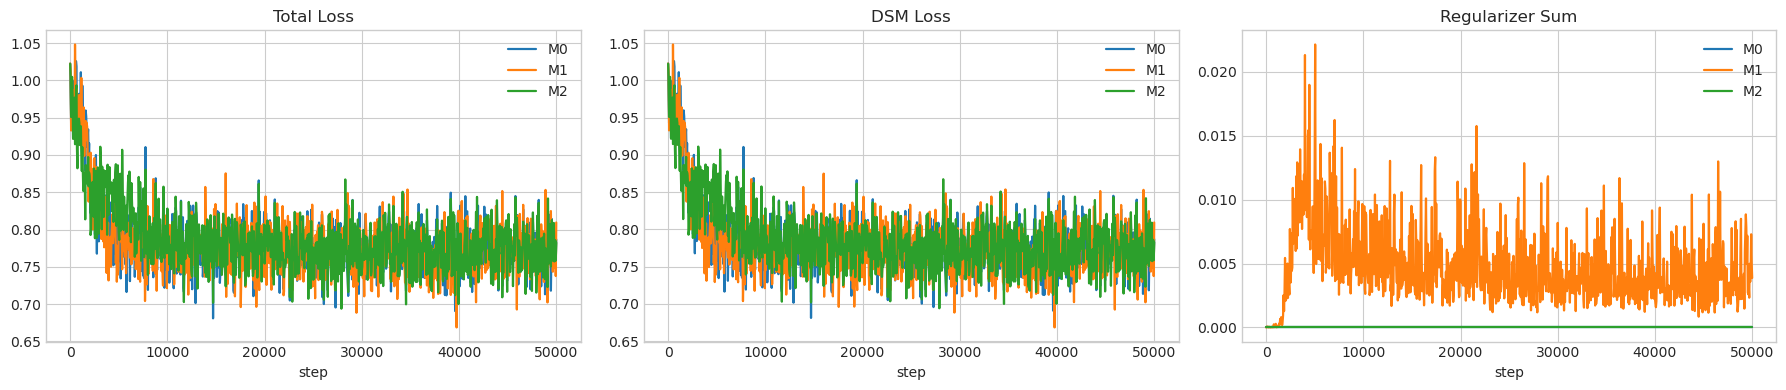

In [5]:
# ============================
# 1) Training Curves
# ============================

train_frames = []
for model_id, run_dir in toy_runs.items():
    df = read_csv_if_exists(run_dir / 'metrics.csv')
    if df.empty:
        continue
    df['model_id'] = model_id
    train_frames.append(df)

train_df = pd.concat(train_frames, ignore_index=True) if train_frames else pd.DataFrame()
display(train_df.head())

if not train_df.empty:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    for model_id in MODEL_ORDER:
        sub = train_df[train_df['model_id'] == model_id]
        if sub.empty:
            continue

        axes[0].plot(sub['step'], sub['loss_total'], label=model_id, linewidth=1.6)
        axes[1].plot(sub['step'], sub.get('loss_dsm', np.nan), label=model_id, linewidth=1.6)

        reg_total = np.zeros(len(sub), dtype=float)
        for col in ['loss_sym', 'loss_loop', 'loss_loop_multi', 'loss_cycle', 'loss_match']:
            if col in sub.columns:
                reg_total = reg_total + sub[col].fillna(0.0).to_numpy()
        axes[2].plot(sub['step'], reg_total, label=model_id, linewidth=1.6)

    axes[0].set_title('Total Loss')
    axes[1].set_title('DSM Loss')
    axes[2].set_title('Regularizer Sum')
    for ax in axes:
        ax.set_xlabel('step')
        ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('metrics.csv not found for detected runs.')


In [6]:
# ============================
# 2) FID vs NFE
# ============================

fid_frames = []
for model_id, run_dir in toy_runs.items():
    df = read_csv_if_exists(run_dir / 'eval' / 'fid_vs_nfe.csv')
    if df.empty:
        continue
    df['model_id'] = model_id
    fid_frames.append(df)

fid_df = pd.concat(fid_frames, ignore_index=True) if fid_frames else pd.DataFrame()
display(fid_df.head())

if not fid_df.empty:
    fig, ax = plt.subplots(figsize=(8, 5))
    for model_id in MODEL_ORDER:
        sub = fid_df[(fid_df['model_id'] == model_id) & (fid_df['sampler'] == fid_df['sampler'].iloc[0])]
        if sub.empty:
            continue
        sub = sub.sort_values('nfe')
        ax.plot(sub['nfe'], sub['fid'], marker='o', label=model_id)

    ax.set_title('Toy FID vs NFE')
    ax.set_xlabel('NFE')
    ax.set_ylabel('FID')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('eval/fid_vs_nfe.csv not found. Set RUN_EVAL_IF_MISSING=True and run again.')


""


eval/fid_vs_nfe.csv not found. Set RUN_EVAL_IF_MISSING=True and run again.


In [7]:
# ============================
# 3) Integrability vs Sigma
# ============================

def normalize_integrability_df(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize legacy/new integrability CSV formats to long schema.

    Args:
        df: Raw integrability DataFrame from eval output.

    Returns:
        Long-format DataFrame with columns including
        `metric_name`, `sigma_lo`, `sigma_hi`, `value`.
    """
    if df.empty:
        return df

    if 'metric_name' in df.columns and 'value' in df.columns:
        return df.copy()

    # 레거시 wide-format(r_sym, r_loop)을 long-format으로 변환한다.
    rows = []
    for metric_col, metric_name in [('r_sym', 'r_sym'), ('r_loop', 'r_loop_multi_total')]:
        if metric_col not in df.columns:
            continue
        tmp = df[['bin', 'sigma_lo', 'sigma_hi', metric_col]].copy()
        tmp['count'] = df.get('count', np.nan)
        tmp['metric_name'] = metric_name
        tmp['scale_delta'] = ''
        tmp['cycle_len'] = ''
        tmp['value'] = tmp[metric_col]
        rows.append(tmp[['bin', 'sigma_lo', 'sigma_hi', 'count', 'metric_name', 'scale_delta', 'cycle_len', 'value']])

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()


integ_frames = []
for model_id, run_dir in toy_runs.items():
    raw = read_csv_if_exists(run_dir / 'eval' / 'integrability_vs_sigma.csv')
    if raw.empty:
        continue
    df = normalize_integrability_df(raw)
    if df.empty:
        continue
    df['model_id'] = model_id
    df['sigma_mid'] = np.sqrt(df['sigma_lo'].astype(float) * df['sigma_hi'].astype(float))
    integ_frames.append(df)

integ_df = pd.concat(integ_frames, ignore_index=True) if integ_frames else pd.DataFrame()
display(integ_df.head())

if not integ_df.empty:
    metrics_to_plot = ['r_sym', 'r_loop_multi_total', 'r_cycle_total']
    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(6 * len(metrics_to_plot), 4), sharex=True)
    if len(metrics_to_plot) == 1:
        axes = [axes]

    for ax, metric_name in zip(axes, metrics_to_plot):
        sub_all = integ_df[integ_df['metric_name'] == metric_name]
        if sub_all.empty:
            ax.set_title(f'{metric_name} (no data)')
            continue

        for model_id in MODEL_ORDER:
            sub = sub_all[sub_all['model_id'] == model_id].sort_values('sigma_mid')
            if sub.empty:
                continue
            ax.plot(sub['sigma_mid'], sub['value'], marker='o', label=model_id)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(metric_name)
        ax.set_xlabel('sigma (bin midpoint)')

    axes[0].set_ylabel('value')
    axes[0].legend()
    plt.tight_layout()
    plt.show()
else:
    print('eval/integrability_vs_sigma.csv not found. Set RUN_EVAL_IF_MISSING=True and run again.')


""


eval/integrability_vs_sigma.csv not found. Set RUN_EVAL_IF_MISSING=True and run again.


/home/junyeobe/projects/Advance_score/src/utils/checkpoint.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(Path(path), map_location=map_location)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

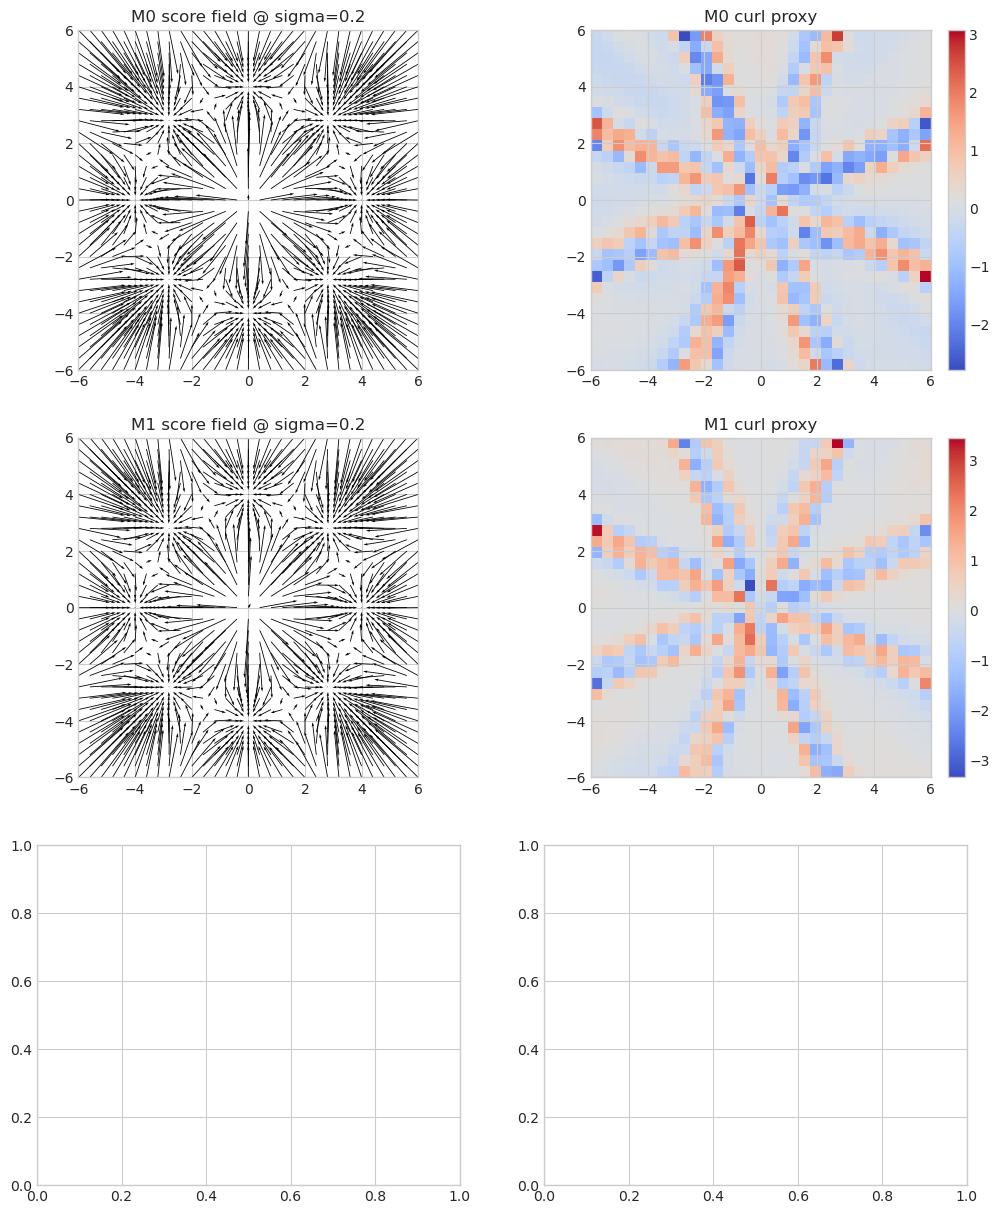

In [8]:
# ============================
# 4) Vector Field + Curl Heatmap
# ============================

SIGMA_VIS = 0.20
GRID_POINTS = 31

available_models = [m for m in MODEL_ORDER if m in toy_runs]
if not available_models:
    print('No toy runs detected.')
else:
    fig, axes = plt.subplots(len(available_models), 2, figsize=(12, 5 * len(available_models)))
    if len(available_models) == 1:
        axes = np.array([axes])

    for row_idx, model_id in enumerate(available_models):
        run_dir = toy_runs[model_id]
        cfg, model, score_fn = load_model_score_fn(run_dir, DEVICE)

        X, Y, U, V = evaluate_score_grid(
            score_fn=score_fn,
            sigma_value=SIGMA_VIS,
            xlim=(-6, 6),
            ylim=(-6, 6),
            points=GRID_POINTS,
            device=DEVICE,
        )

        xs = np.linspace(-6, 6, GRID_POINTS)
        ys = np.linspace(-6, 6, GRID_POINTS)
        curl = finite_diff_curl(U, V, xs=xs, ys=ys)

        ax_field = axes[row_idx, 0]
        ax_field.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=10)
        ax_field.set_title(f'{model_id} score field @ sigma={SIGMA_VIS}')
        ax_field.set_xlim(-6, 6)
        ax_field.set_ylim(-6, 6)
        ax_field.set_aspect('equal')

        ax_curl = axes[row_idx, 1]
        im = ax_curl.imshow(curl, extent=[-6, 6, -6, 6], origin='lower', cmap='coolwarm')
        ax_curl.set_title(f'{model_id} curl proxy')
        ax_curl.set_aspect('equal')
        fig.colorbar(im, ax=ax_curl, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


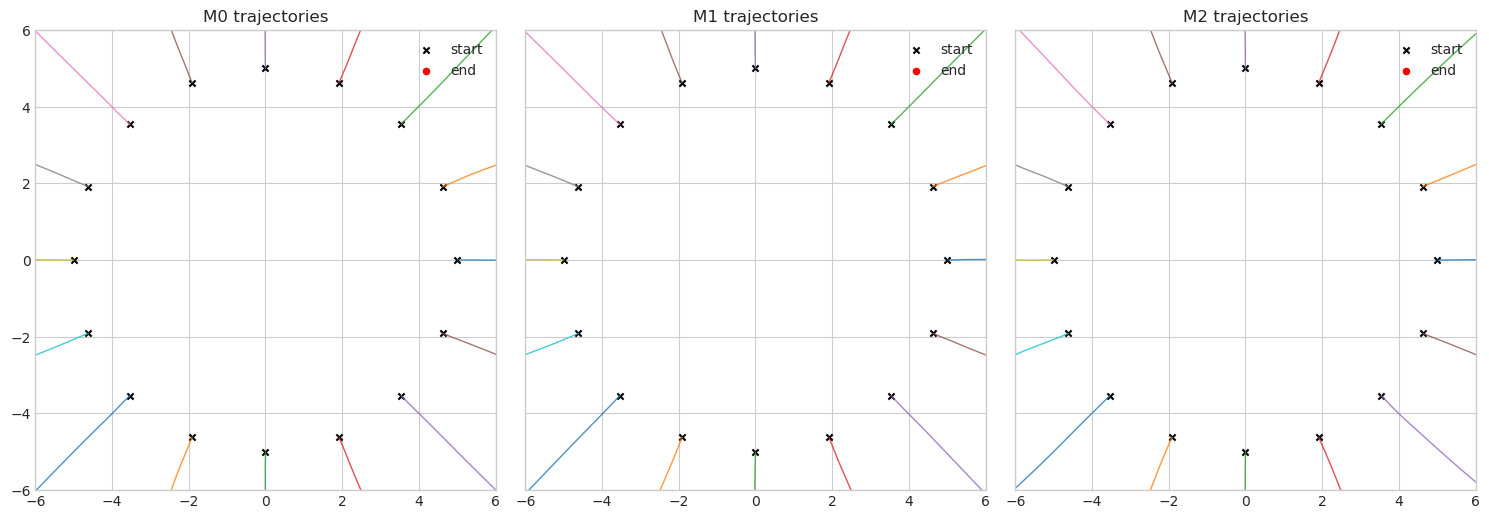

In [9]:
# ============================
# 5) Sampling Trajectories (Heun)
# ============================

N_TRAJ = 16
NFE = 50
RADIUS = 5.0

angles = np.linspace(0, 2 * np.pi, N_TRAJ, endpoint=False)
init_np = np.stack([RADIUS * np.cos(angles), RADIUS * np.sin(angles)], axis=1).astype(np.float32)
init_x = torch.from_numpy(init_np).to(DEVICE)

available_models = [m for m in MODEL_ORDER if m in toy_runs]
if not available_models:
    print('No toy runs detected.')
else:
    fig, axes = plt.subplots(1, len(available_models), figsize=(5 * len(available_models), 5), sharex=True, sharey=True)
    if len(available_models) == 1:
        axes = [axes]

    for ax, model_id in zip(axes, available_models):
        run_dir = toy_runs[model_id]
        cfg, model, score_fn = load_model_score_fn(run_dir, DEVICE)
        sigma_min = float(cfg['loss']['sigma_min'])
        sigma_max = float(cfg['loss']['sigma_max'])

        score_requires_grad = model_id in {'M2', 'M4'}
        _, stats = sample_heun(
            score_fn=score_fn,
            shape=tuple(init_x.shape),
            sigma_min=sigma_min,
            sigma_max=sigma_max,
            nfe=NFE,
            device=DEVICE,
            init_x=init_x.clone(),
            score_requires_grad=score_requires_grad,
            return_trajectory=True,
        )

        traj = [t.detach().cpu().numpy() for t in stats['trajectory']]
        traj_arr = np.stack(traj, axis=0)  # [T, B, 2]

        for i in range(traj_arr.shape[1]):
            ax.plot(traj_arr[:, i, 0], traj_arr[:, i, 1], linewidth=1.0, alpha=0.8)

        ax.scatter(traj_arr[0, :, 0], traj_arr[0, :, 1], s=20, c='black', marker='x', label='start')
        ax.scatter(traj_arr[-1, :, 0], traj_arr[-1, :, 1], s=20, c='red', marker='o', label='end')
        ax.set_title(f'{model_id} trajectories')
        ax.set_aspect('equal')
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


## 사용 팁
- `RUN_EVAL_IF_MISSING=True`로 바꾸면 eval CSV가 없는 런에 대해 자동으로 `main_eval`을 실행합니다.
- `SIGMA_VIS`, `GRID_POINTS`, `NFE`를 바꿔서 해상도/속도 균형을 조절할 수 있습니다.
- 새 실험 경로(`runs/toy/M3/seed1` 등)를 보고 싶으면 `find_toy_run_dirs(..., seed_name='seed1')`로 변경하세요.
